#**Electric Machine Simulation in Python | Permanent Magnet DC Device**


---


This notebook is the second entry of a larger collection of notebooks on electric machine simulation in Python. These electrodynamics simulations can ultimately be used to quickly test and iterate on controller designs. This notebook is by no means exhaustive; I am writing this mainly to document my modeling process as I learn more about these machines. 

This particular notebook covers the modeling and simulation of a permanent magnet DC machine. The electrodynamics for these machines is relatively straightforward, so I also thought it would be interesting to experiment with numerical integration; I solved the dynamics with both Euler and Runge-Kutta methods. I also wanted to evaluate the accuracy of the simulation, so I found parameters and a datasheet for a popular model of permanent magnet DC motor to compare the model outputs to. 

I chose to develop a lumped-parameter model for a general representation of this machine at no load torque, represented schematically as follows (using my favorite open source diagramming software, [draw.io](https://github.com/jgraph/drawio)):

**Permanent Magnet DC Machine:**

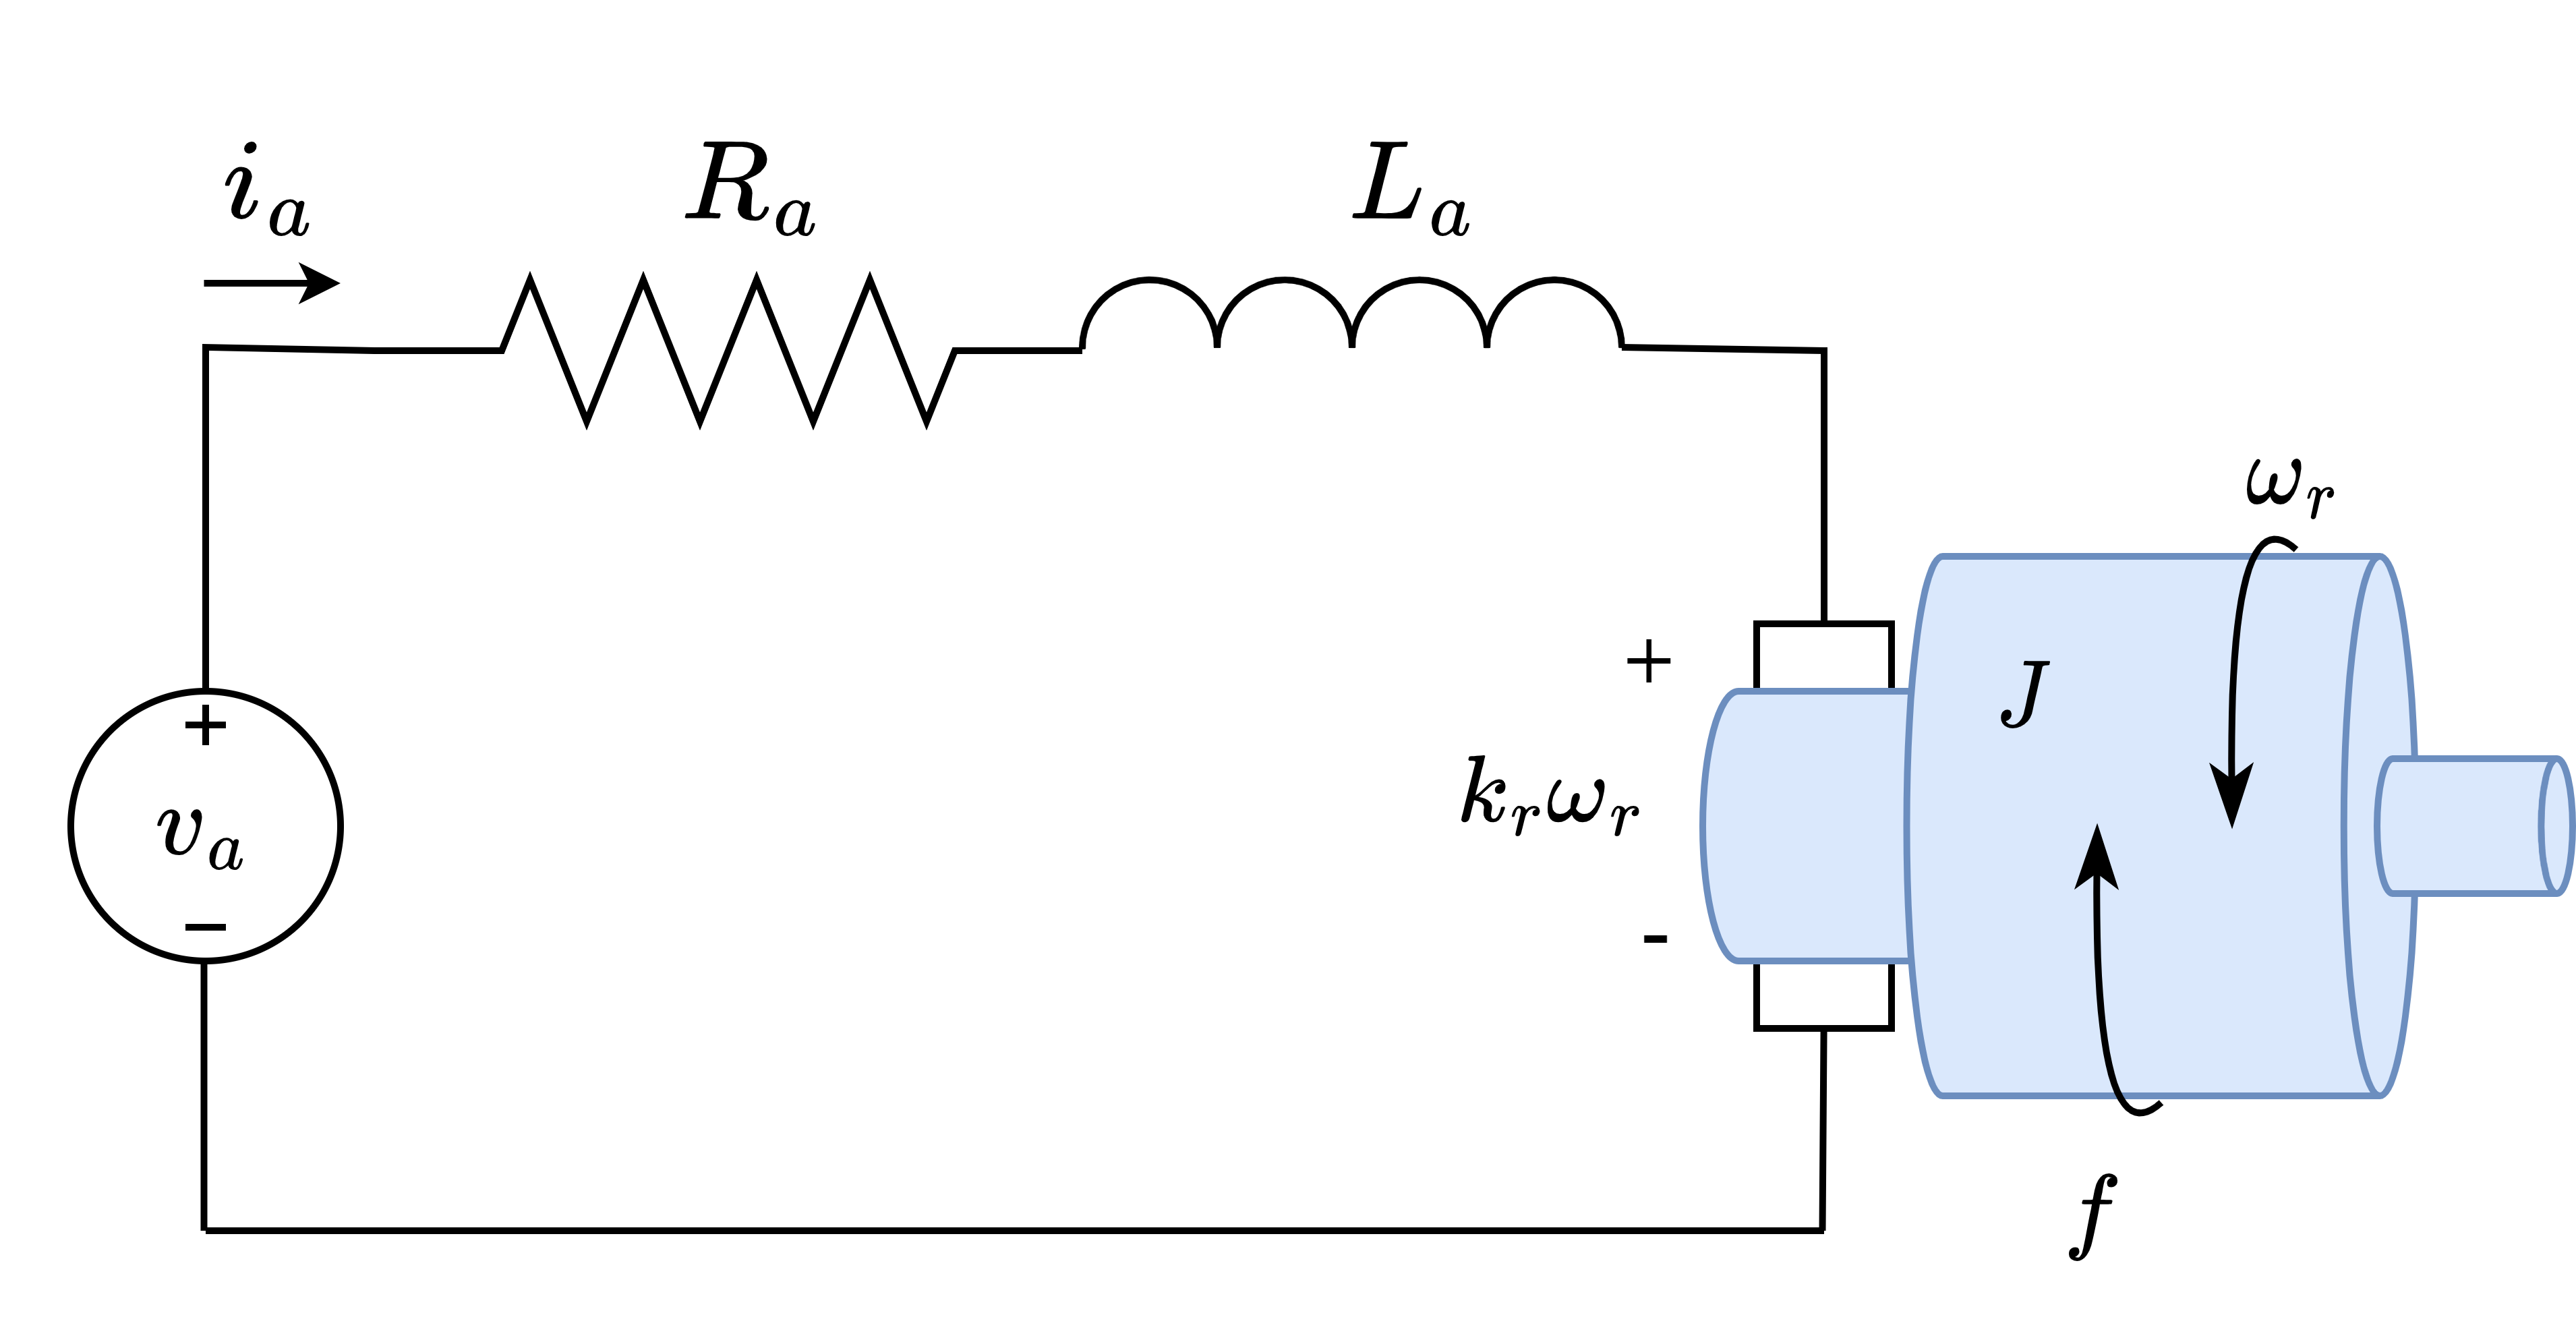

#Physics-Based Analytical Model


---

It is natural to begin the modeling process of an electric machine by developing a formulation for flux linkage ($\lambda$) - current ($i$) relationship. It is also useful to form this relationship for machines with more an arbitrary number of poles $N_p$, as pole number is a critical design parameter of practical electric machines. This analysis was avoided in the single coil reluctance device notebook for simplicity, but we consider it here in developing the flux linkage - current relationship for a general DC machine (either permanent magnet or field wound):<br><br>

\begin{gather*}
\lambda_a = [L_0 + L_2\cos(N_p\theta_{af})]i_a - \lambda_{af}\cos(\frac{N_p}{2}\theta_{af}) \tag{1}
\end{gather*}<br>

Here, armature winding inductance $L_a$ is decomposed as the difference $L_0-L_2$. The angle between the rotor and stator magnetic fields is taken as $\theta_{af}$. The armature winding has some resistance $R_a$. The flux linked to by the stator field to the armature $\lambda_{af}$ is related to the armature flux linkage $\lambda_{a}$ by a function of $\theta_{af}$.<br><br>

With equation 1, we can then develop a form for the electrodynamics of a general DC machine with our modified form of Faraday's law:<br><br>

\begin{gather*}
v = Ri + \frac{d\lambda}{dt} \tag{2}
\end{gather*}<br>

Substituting (1) into (2), it can be shown that our electrodynamics for a permanent magnet machine (i.e. $\lambda_{af} = \Lambda_{PM}$) are defined by:<br><br>

\begin{gather*}
v_a = R_ai_a + L_a\frac{di_a}{dt}+\frac{N_p}{2}\Lambda_{PM}\omega_r\\
= R_ai_a + L_a\frac{di_a}{dt}+k_r\omega_r \tag{3}
\end{gather*}<br>

In (3), the constant $k_r$ was introduced to simplify the voltage proportional to rotor speed $w_r$. This voltage is commonly known as "back-EMF", and $k_r$ is known as the torque/back-EMF coefficient. It can be shown that the torque produced by a brushed DC motor is, like back-EMF, proportional by $k_r$ to a system state, in this case, armature current $i_a$. To solve the electrodynamics, we want to establish an explicit form for the highest order derivative term which we can use for numerical integration. Thus, we are interested in solving for $i_a$ as the "output" of this electrodynamic system, so we need to rearrange (3) to form:<br><br>

\begin{gather*}
\frac{di_a}{dt} = \frac{1}{L_a}[v_a - R_ai_a - k_r\omega_r ] \tag{4}
\end{gather*}<br>

Now, lets consider the mechanical dynamics of this system. Rotors have non-zero inertia, and non-zero frictional or damping forces acting against motion due to both constraint bearings and the carbon brushes that aid commutation. From Euler's expression for rotational motion, we can form:<br><br>

\begin{gather*}
\Sigma M = T_m - T_f =J\frac{dw_r}{dt} \tag{5}
\end{gather*}<br>

$T_m$ represents motor torque produced by armature current $T_m = k_ri_a$, as discussed previously. $T_f$ encapsulates all friction present in the system, and is assumed to be dominated by dry Coulomb friction as opposed to viscous damping, and hence is left as a constant in this simulation (as opposed to proportional to $w_r$. Just as we did for current, we can rearrange (4) to form an explicit expression for $\frac{dw_r}{dt}$ to set up the application of a numerical integrator:<br><br>

\begin{gather*}
\frac{dw_r}{dt} = \frac{k_ri_a - T_f}{J} \tag{6}
\end{gather*}<br>



#Simulation Strategy


---
Having developed a set of ordinary differential equations that capture the dynamics of a general permanent magnet DC machine, we can proceed to solve them for arbitrary DC machine parameters. In high school, I participated in the FIRST Robotics Competition (proud to be a product of Team #8, [Paly Robotics](https://www.palyrobotics.com/)) which relied on the [CIM](https://www.andymark.com/products/2-5-in-cim-motor) motor as its permanent magnet DC workhorse. So, I snagged a datasheet and did a little digging to find machine parameters needed to initialize the simulation, and also whipped up a couple functions to simplify some math later on:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Euler Integrator
def eintegrate(x, dx_dt, d_t):
    return (x + (dx_dt*d_t))

## Convert Oz-in to N-m
def ozin2nm(ozin):
    return (ozin*0.0070616)

## Device Parameters
L_a = 59e-6 # Armature inductance (H) - Per Chief Delphi thread
r = 0.091 # Coil resistance per datasheet
# r = 630e-3 # Coil resistance needed to get model to fit no load current and speed
J_r = 0.000075 # Rotor inertia from Chief Delphi

## Compute Motor Constant from datasheet
t_stall = ozin2nm(343.4)
i_stall = 131
i_nl = 2.7
k_r = t_stall/(i_stall) # Motor Constant

## Compute Damping Coefficient from datasheet
w_nl = 5310 * ((2*np.pi)/60) # Convert no load speed from datasheet to rad/s
b = (k_r*i_nl)/w_nl 

## Dry Friction Model 
f = (k_r*i_nl) # Same compution as for damping coefficent but without w_nl proportionality


Note that the torque/back-EMF constant `k_r` is found by leveraging the proportional relationship with current. This parameter is quite useful, so it is generally included in the datasheets for these kinds of machines; I computed it here just for kicks and it agreed well with the provided value.

For mechanical model losses, I wanted to test both Coulomb (dry) friction and viscous damping. Permanent magnet DC machines are subject to mechanical loss via both ball bearings and carbon brushes that contact the commutator. It is common to model ball bearing losses as viscous damping due to bearing grease under the assumption that bearing balls themselves roll without slip between bearing races, and the contact between the brushes and commutator is generally dry. 

To calculate the damping coefficient from the device datasheet, I evaluated equation 5 at steady state (derivatives = 0, taking $T_f =$ `b*w_nl`), where `w_nl` is no load speed from the datasheet). I computed dry friction the same way, but without proportionality with rotor speed (taking $T_f =$ `f`). I suspect in reality the mechanical loss behaves as some weird nonlinear weighting of both dry friction and viscous damping; this setup just lets me test both and see if one or the other dominates in comparison with the datasheet curves.

For this simulation, I wanted to experiment with the [Runge-Kutta Order 4](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4) numerical integrator in addition to the Euler integrator that I have been using in previous simulations. The advantage of RK4 over Euler is that its error is much smaller, which allows for larger simulation time steps to be used without sacrificing accuracy. I wanted to compare the performance of both here on this relatively simple physical model to get some intuition on how they perform and how to select one or the other. With some simulation initialization:





In [2]:
## Device Initial Conditions
i = 0 # Initial current
i_euler = 0
i_0 = 0
w_r = 0 # Initial rotor angular velocity
w_r_euler = 0

## Simulation Parameters
dt = 0.0015 # Integration time step
t_end = 1 # Time at which to stop simulating
time = np.arange(0,t_end,dt) # Time discretization

## Simulation Setup
simlength = time.size 
simstep = 0
w_r_store = np.array([])
i_store = np.array([])
w_r_store_euler = np.array([])
i_store_euler = np.array([])

Let's start with the Euler integration method, which makes use of the `eintegrate` function defined earlier to solve the ODEs derived above (equations 4 and 6). For sake of integration algorithm comparison, lets assume that dry friction is the dominant mechanical loss:

In [3]:
## Euler Simulation Loop
while simstep < simlength:

    # Inputs/Controller
    v = 12 # Voltage as function of time

    # Choose torque loss model
    Tf = f # Dry friction loss
    #Tf = b*w_r_euler # Viscous damping loss

    # Current Physics
    di_dt_euler = (1/L_a) * (v - (r*i_euler) - (k_r*w_r_euler))
    i_euler = eintegrate(i_euler,di_dt_euler,dt)

    #Rotor Speed Physics
    dw_r_dt_euler = ((k_r*i_euler)-Tf)/J_r 
    w_r_euler = eintegrate(w_r_euler,dw_r_dt_euler,dt)

    #Rad/s -> RPM
    w_r_rpm_euler = w_r_euler *(1/(2*np.pi))*60


    # Store for plot
    i_store_euler = np.append(i_store_euler,i_euler)
    w_r_store_euler = np.append(w_r_store_euler,w_r_rpm_euler)

    # Advance Simulation Step
    simstep = simstep + 1

And now the RK4 integration, which uses manual step definition. The `scipy` has an inbuilt RK4 integrator, but I wanted to manually implement it to build familiarity and understanding of how it works (an implimentation using `scipy`'s inbuilt function is shown later):

In [4]:
simstep = 0

## Runge-Kutta Order 4 Simulation Loop
while simstep < simlength:
    # Inputs/Controller
    v = 12 # Voltage as function of time

    # Current Physics
    def di_dt(i_t,w_r_t):
        return ((1/L_a) * (v - (r*i_t) - (k_r*w_r_t)))
    
    # Rotor Speed Physics
    def dw_r_dt(i_w_t):
        return (((k_r*i_w_t)-f)/J_r )
    
    # RK4 Implementation
    i_k1 = di_dt(i,w_r)
    i1 = i+(i_k1 * dt/2)

    i_k2 = di_dt(i1,w_r) 
    i2 = i+(i_k2 * dt/2)

    i_k3 = di_dt(i2,w_r)
    i3 = i+(i_k3 * dt)

    i_k4 = di_dt(i3,w_r)

    i = (i + (dt/6)*(i_k1 + (2 * i_k2) + (2 * i_k3) + i_k4))

    w_k1 = dw_r_dt(i)
    w_k2 = dw_r_dt(i1)
    w_k3 = dw_r_dt(i2)
    w_k4 = dw_r_dt(i3)

    w_r = w_r + (dt/6) * (w_k1 + (2 * w_k2) + (2 * w_k3) + w_k4)

    #Rad/s -> RPM
    w_r_rpm = w_r *((1/(2*np.pi)) * 60)

    # Store for plot
    i_store = np.append(i_store,i)
    w_r_store = np.append(w_r_store,w_r_rpm)

    # Advance Simulation Step
    simstep = simstep + 1

#Euler vs. Runge-Kutta Order 4


---
Obviously, the RK4 implementation takes more lines and more computation steps than the Euler implementation. The thinking is that there is some length of simulation time that makes the larger time step afforded by RK4 accuracy worth the extra computation on the per-step basis. 

I messed around a bunch on my native simulation script with different values of `dt` to see how sensitive both integrators were, and found a breakpoint at `dt = 0.0015`, which I left in this notebook for the sake of demonstration. Plotting the response of the simulated machine to a step command of 12V with both integrators:

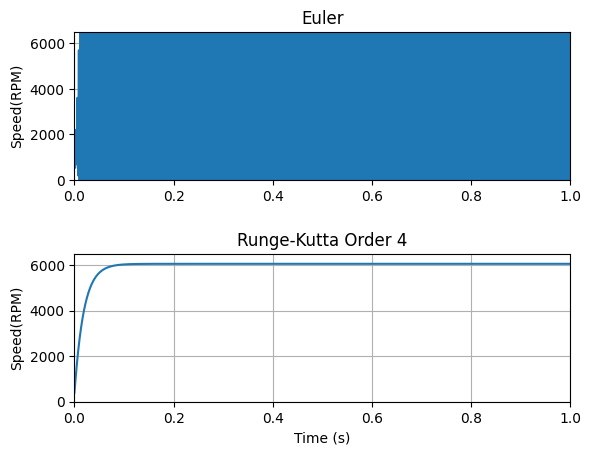

In [5]:
## Plots
fig, axs = plt.subplots(2)

axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlim([0, 1])
axs[1].set_xlim([0, 1])
axs[0].set_ylim([0, 6500])
axs[1].set_ylim([0, 6500])

axs[0].plot(time, w_r_store_euler)
axs[0].set_title('Euler')

axs[1].plot(time, w_r_store)
axs[1].set_title('Runge-Kutta Order 4')

axs[0].set_ylabel('Speed(RPM)')
axs[1].set_ylabel('Speed(RPM)')
axs[1].set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.5)
plt.show()


Clearly, the RK4 integrator can handle this step size and produces a reasonable looking step response while the Euler blows up and is completely unreadable. Despite the implication of this result, in my tuning of `dt` to find this break, I found that the RK4 integrator was susceptible to failure beyond about `dt = 0.0018`, and the Euler only needed a bump to `dt = 0.0012`to work. The  0.006 time step difference doesn't get you much on this order of simulation time scale, maybe a second or two of extra script runtime, but for longer simulations to test speed control or position control to different references or simulating machines with larger inertias, the RK4 can come in handy.

Furthermore, thinking ahead to more comprehensive motor simulation projects, Runge-Kutta methods can be implemented very elegantly using `scipy.integrate.solve_ivp` on systems of differential equations in state space representation. State space is compact and standard, and thus more scalable in the long term as my simulation needs change. Thus, I thought it would be prudent to come up with such an implementation.

#Implementing `scipy.integrate.solve_ivp`


---
The first step here is to develop a state space representation of the system physics built on first order ODEs. For this machine, lets choose states $x$ to be $i$ and $w_r$:<br><br>

\begin{gather*}
x = \begin{bmatrix} i \\ w_r \end{bmatrix}
\end{gather*}<br>

Inputs $u$ are a slightly trickier to deal with, as in order to fit the state space form $u$ needs to include a sum of both motor load torque $T_L$ (unmodeled in preceding simulation due to no load condition) and dry friction $T_f$. The other input to the system is voltage $v$:<br><br>

\begin{gather*}
u = \begin{bmatrix} v \\  T_L + T_f\end{bmatrix}
\end{gather*}<br>

Now with equations 4 and 6 we can create our state space model. Note for this model, I expanded $T_f$ as listed in equation 6 into viscous and dry components, as realistically both act on the machine:<br><br>

\begin{gather*}
\dot{x} = \begin{bmatrix} \frac{di}{dt} \\  \frac{dw_r}{dt}\end{bmatrix} = \begin{bmatrix} -\frac{R}{L_a} & -\frac{k_r}{L_a} \\  \frac{k_r}{J} & -\frac{b}{J}\end{bmatrix}x + \begin{bmatrix} \frac{1}{L_a} & 0 \\  0 & -\frac{1}{J}\end{bmatrix}u
\end{gather*}<br>

Now we can port this setup into a compact function to define the physics for the system, which, for the purpose of utilising with `solve_ivp`, takes arguments of `t` (despite function body not doing anything with it) and `x`, the state vector, and returns `xdot` the state equation form of the system dynamics. Note that this means we can ultimately come up with a similar, general definition for every class of motor we want to simulate (SMPM, induction, etc.) that all have this standard structure:

```
def pmdcPhysics(t,x):
    ## States
    i = x[0] 
    w_r = x[1]

    ## Governing ODEs
    di_dt = (1/L_a) * v + (-r/L_a) * i + (-k_r/L_a) * w_r 
    dw_r_dt = (k_r/J_r) * i + (-b/J_r) * w_r + (-1/J_r) * (T_l + T_f)

    ## State Equation
    xdot = np.array([di_dt, dw_r_dt])

    return xdot
  ```
In context, adding some variables to capture state space input load split described earlier:

In [6]:
## Input Loads
T_l = 0
T_f = 0

def pmdcPhysics(t,x):
    ## States
    i = x[0] 
    w_r = x[1]

    ## Governing ODEs
    di_dt = (1/L_a) * v + (-r/L_a) * i + (-k_r/L_a) * w_r 
    dw_r_dt = (k_r/J_r) * i + (-b/J_r) * w_r + (-1/J_r) * (T_l + T_f)

    ## State Equation
    xdot = np.array([di_dt, dw_r_dt])

    return xdot

Then all we need are initial conditions and a simulation time span:

In [12]:
## Device Initial Conditions
ics = np.array([0, 0]) # Matched to order of state definition in physics function

## Simulation Time
tspan = np.array([0, 1])

And we can solve the dynamics in one line:

In [13]:
sim = solve_ivp(pmdcPhysics, tspan, ics,'RK45') # Solve!

States can then be accessed by indexing into `sim` which also stores time, and then plotted as usual:

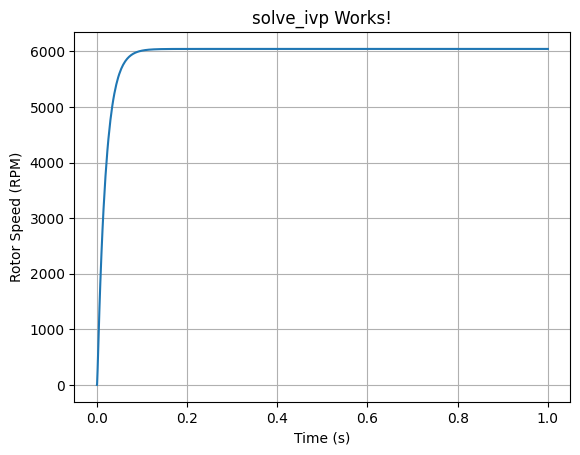

In [15]:
isim = sim.y[0] 
wrsim_rads = sim.y[1] 
wrsim_rpm = wrsim_rads*(1/(2*np.pi))*60
time = sim.t

plt.plot(time, wrsim_rpm)
plt.xlabel('Time (s)')
plt.ylabel('Rotor Speed (RPM)')
plt.grid(True)
plt.title('solve_ivp Works!')
plt.show()

#Simulated Steady State Behavior


---
Getting back to motors now, lets take a look at the simulation output. To get a feel for the dry friction effects versus viscous damping I opted to compute steady state operating points with original non-`solve_ivp` RK4 integrator (arbitrary decision). Doing some quick computations on the simulation outputs, we can find some key motor performance metrics, namely steady-state speed $\omega_r{ss}$, steady state armature current, and efficiency defined as (7):<br><br>

\begin{gather*}
\eta= \frac{P_{mech}}{P_{elec}} = \frac{\omega_rT_m}{V_aI_a} = \frac{\omega_rK_rI_a}{V_aI_a} \tag{7}
\end{gather*}<br>

Note that this simulation is occuring at no-load; there is no load torque. The current required to accelerate the motor is only due to rotor inertia and friction force. 

In [17]:
## Steady State Calculations
w_r_ss = ((v-(r*i))/k_r)*(1/(2*np.pi))*60
w_r_rpm = round(w_r_rpm,0)
torque = k_r*i
mechpower = w_r*(torque-f)
elecpower = v*i
eta = round(100 * (mechpower/elecpower),1)
i = round(i,2)
mechpower = round(mechpower,2)

print("\n Simulation Complete ;) \n")
print("Speed RK4 (RPM): ", w_r_rpm)
print("Current RK4 (A): ", i)
print("Mechanical Power RK4 (W): ", mechpower)
print("Efficiency RK4: ", eta)


 Simulation Complete ;) 

Speed RK4 (RPM):  6064.0
Current RK4 (A):  2.7
Mechanical Power RK4 (W):  0.0
Efficiency RK4:  0.0


The no load current of 2.7A hits the datasheet spec, as expected. Fascinatingly, at this current (which should be no load current), the no load speed given by the datasheet is 5310 RPM, which means the simulation is off by 14%- there is unmodeled rotor core loss that could contribute to this difference, and of course the parameters used in the model could be off by a bit relative to the machine tested in the datasheet; a couple of parameters weren't given in the datasheet were found in random entries on the FIRST robotics community forum, [Chief Delphi](https://www.chiefdelphi.com/). I messed around with the resistance value (see comment in that code up near the top and found a value that made the no load speed match up, but it was like 2 orders of magnitudes greater than the datasheet value, well beyond any implicit datasheet precision error. Mechanical power and therefore efficiency are 0 as expected as the motor isn't applying torque to any input load. Anyways, I am satisfied enough with this simulation as a learning endeavor, so I'll accept that 14% error and move on.